In [1]:
import glob, matplotlib, re, math, pandas, sys, argparse
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#from models import autoencoder
import torch
randomSeed = 5
import pytorch_lightning as pl
pl.seed_everything(randomSeed)
torch.manual_seed(randomSeed)
import random
random.seed(randomSeed)
np.random.seed(randomSeed)
from torch import nn, FloatTensor
from torch.autograd import Variable
from data_ttMET_delphes import get_DataLoaders
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
font = {'size':14}
matplotlib.rc('font', **font)

Global seed set to 5


In [131]:
args = argparse.Namespace()
args.data = '/users/whopkins/sigclustering/sigclustering/python/ttMET_delphes_sepSigs.h5'
args.time_throughput = False
args.batch_size = 512
loadBranches = ['MET', 'HT', 'pT_1jet', 'pT_2jet', 'pT_3jet', 'pT_4jet', 'nj_good', 'num_bjets', 'm_1jet', 'm_2jet']
signals = ['sig_1300_1', 'sig_300_1']#, 'sig_800_1' , 'sig_800_500']
trainDataLoader, testDataLoader, allData, scaledData, selectedSigs, reducedData = get_DataLoaders(args, loadBranches, signals=signals, minSize=1000, reduceData=True)#, scaler=quantScaler)
print(allData.keys())


No preselection specified
Number of signal samples: 2
Total number of events to be clustered: 38803
We will make all samples have the following raw event yield: 1809
using only samples:  ['sig_1300_1', 'sig_300_1']
aeData.shape: (3618, 10)
aeData.columns: Index(['MET', 'HT', 'pT_1jet', 'pT_2jet', 'pT_3jet', 'pT_4jet', 'nj_good',
       'num_bjets', 'm_1jet', 'm_2jet'],
      dtype='object')
tempWeights.shape: (3618, 91)
samples: ['sig_1300_1', 'sig_300_1']
tmp =      MET   HT  pT_1jet  pT_2jet  pT_3jet  pT_4jet  nj_good  num_bjets  m_1jet  \
min  0.0  0.0      0.0      0.0    -0.05    -0.05      0.0        0.0     0.0   
max  1.0  1.0      1.0      1.0     1.00     1.00      1.0        1.0     1.0   

     m_2jet  
min     0.0  
max     1.0  
Index(['nj_good', 'num_bjets', 'pT_1jet', 'eta_1jet', 'phi_1jet', 'm_1jet',
       'pT_2jet', 'eta_2jet', 'phi_2jet', 'm_2jet', 'pT_3jet', 'eta_3jet',
       'phi_3jet', 'm_3jet', 'pT_4jet', 'eta_4jet', 'phi_4jet', 'm_4jet',
       'pT_5jet', 'eta

Index(['MET', 'HT', 'pT_1jet', 'pT_2jet', 'pT_3jet', 'pT_4jet', 'nj_good',
       'num_bjets', 'm_1jet', 'm_2jet', 'sampName'],
      dtype='object')
_sig_1300_1__sig_300_1
MET 0.0 1.0
HT 0.0 0.9999999999999999
pT_1jet 0.0 0.9999999999999998
pT_2jet 0.0 1.0
m_1jet 0.0 1.0
m_1jet 0.0 1.0


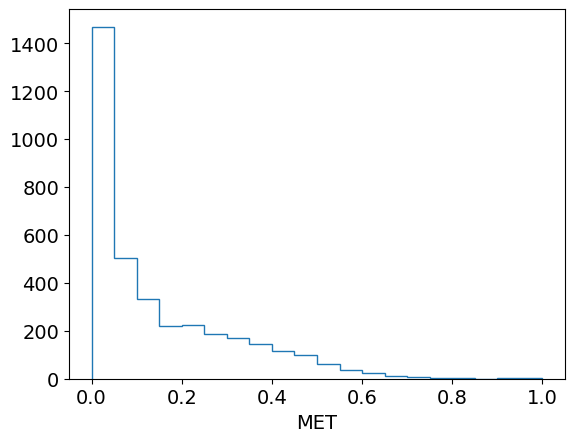

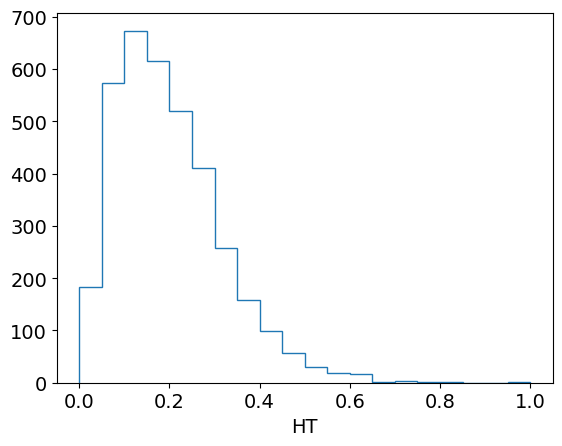

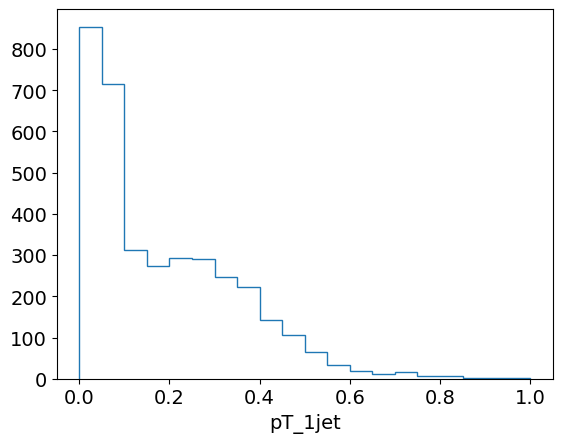

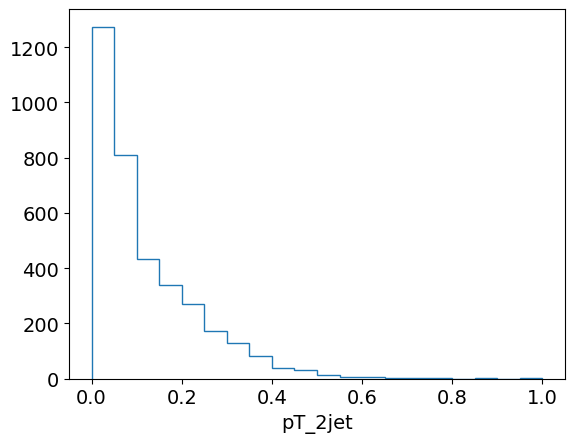

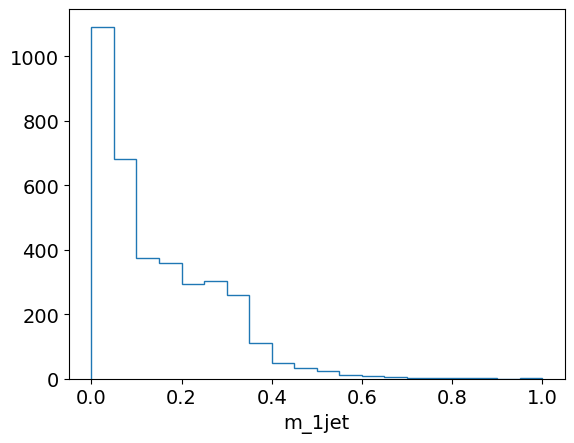

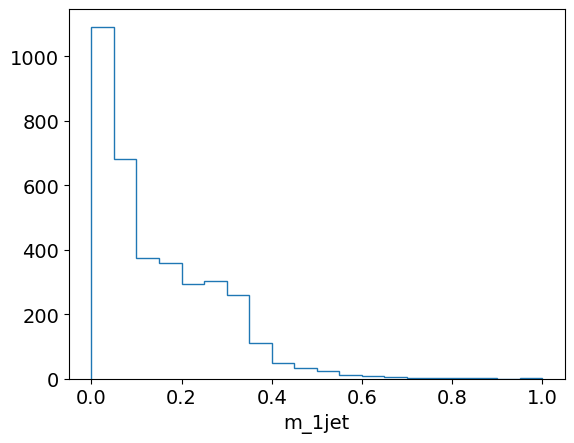

In [132]:
# Let's plot the input variables to make sure we don't have some ugly spikes
cDataWithName = scaledData
#print(scaledData)
doAvg = False
sumStr = ''
if doAvg:
    cDataWithName = reducedData
    sumStr = '_avg'
print(cDataWithName.keys())
trainBranches = ['MET', 'HT', 'pT_1jet', 'pT_2jet', 'm_1jet', 'm_1jet']#, 'pT_3jet', 'pT_4jet']#, 'nj_good']#, 'num_bjets']
varListStr = '_'.join(trainBranches)
data = cDataWithName[cDataWithName.sampName=="sig_1300_1"][trainBranches].copy(deep=True)

# convert to tensors
data_t = FloatTensor(data.to_numpy())
dataset = TensorDataset(data_t, data_t)
instances = len(dataset)

# split train/val
# the rest will be validation
train_ratio = 0.6
train_instances = int(train_ratio*instances)
val_instances = instances - train_instances
ds_train, ds_val = random_split(dataset,
                                [train_instances, val_instances],)
# get dataloaders
batchSize=args.batch_size
train_loader    = DataLoader(ds_train,
                             batch_size=batchSize,
                             shuffle=True,
                             num_workers=8,
                             )
val_loader      = DataLoader(ds_val,
                             batch_size=batchSize,
                             shuffle=False,
                             num_workers=8,
                             )

sigStr = '__'.join(signals)
sigStr = '_'+sigStr

if signals == []:
    sigStr = '_allSignals'
print(sigStr)
nBins = 20
for branch in trainBranches:
    fig, ax = plt.subplots()
    plotData = scaledData[branch]#selectedSigs[branch]
    xMin = np.min(plotData.to_numpy(), axis=0)
    xMax = np.max(plotData.to_numpy(), axis=0)
    print(branch, xMin, xMax)
    dX = (xMax-xMin)/nBins
    bins = [xMin+i*dX for i in range(nBins+1)]
    a = plt.hist(plotData, histtype='step', bins=bins)
    ax.set_xlabel(branch)
    # plt.savefig(f'{branch}{sigStr}.pdf', bbox_inches='tight')
    # plt.savefig(f'{branch}{sigStr}.svg', bbox_inches='tight')
    # plt.savefig(f'{branch}{sigStr}.png', bbox_inches='tight')

In [138]:
from pytorch_lightning import Callback
import copy
class MetricsCallback(Callback):
    """PyTorch Lightning metric callback."""
    def __init__(self):
        super().__init__()
        self.metrics = {}

    def on_epoch_end(self, trainer, pl_module):
        metrics = copy.deepcopy(trainer.callback_metrics)
        
        for metric in metrics:
            if metric not in self.metrics:
                self.metrics[metric] = [metrics[metric]]
            self.metrics[metric].append(metrics[metric])

class VAE(pl.LightningModule):
    def __init__(self, input_dim, latent_dim=1, enc_out_dim=32, alpha=1):
        super().__init__()

        self.save_hyperparameters()
        self.alpha = alpha
        self.stdev = 0.1
        self.kld_beta = 0.2
        self.recon_loss_func = nn.SmoothL1Loss(reduction='none')
        # encoder, decoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim,128),nn.ReLU(),
                                     nn.Linear(128,32),nn.ReLU(),
                                     nn.Linear(32,enc_out_dim),nn.ReLU()
                                     )

        self.decoder = nn.Sequential(nn.Linear(latent_dim,32),nn.ReLU(),
                                     nn.Linear(32,128),nn.ReLU(),
                                     nn.Linear(128,input_dim),
                                     )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    # def gaussian_likelihood(self, x_hat, logscale, x):
    #     scale = torch.exp(logscale)
    #     mean = x_hat
    #     dist = torch.distributions.Normal(mean, scale)

    #     # measure prob of seeing image under p(x|z)
    #     log_pxz = dist.log_prob(x)
    #     return log_pxz.sum()

    # def kl_divergence(self, z, mu, std):
    #     # --------------------------
    #     # Monte carlo KL divergence
    #     # --------------------------
    #     # 1. define the first two probabilities (in this case Normal for both)
    #     p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
    #     q = torch.distributions.Normal(mu, std)

    #     # 2. get the probabilities from the equation
    #     log_qzx = q.log_prob(z)
    #     log_pz = p.log_prob(z)

    #     # kl
    #     kl = (log_qzx - log_pz)
    #     kl = kl.sum(-1)
    #     return kl
    
    def reparameterize(self, mu, logvar):
        '''
        The reparameterisation trick allows us to backpropagate through the encoder.
        '''
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std) * self.stdev
            return eps * std + mu
        else:
            return mu

    def loss_function(self, obs, recon, mu, logvar):
        recon_loss = self.recon_loss_func(recon, obs)
        kld = -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp())
        return recon_loss, kld
    
    def forward(self, batch):
        x = batch
        x_encoded = self.encoder(x)
        mu, logvar = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        
        recon_loss, kld = self.loss_function(x, recon, mu, logvar)
        loss = torch.sum(recon_loss) + self.kld_beta * kld
        
        return recon, mu, logvar, recon_loss, kld, loss
    
    def training_step(self, batch, batch_idx):
        x, _ = batch
        recon, mu, logvar, recon_loss, kld, loss = self.forward(x)
        
        self.log_dict({
            'elbo': loss,
            'kl': kld.mean(),
            'recon_loss': recon_loss.mean(),
            #'reconstruction': recon_loss.mean(),
            'mu':mu.mean(),
            'std':logvar.mean()
            #'kl': kl.mean(),
        })
        
        return loss
#print(data_t.shape, len(trainBranches))   
torch.cuda.empty_cache()
latent_dim = 1
model = VAE(len(trainBranches), latent_dim=latent_dim)
#print(model)
trainer = pl.Trainer(gpus=1, max_epochs=1000, callbacks=[MetricsCallback()], enable_progress_bar = False)
trainer.fit(model, train_loader, val_loader)
metrics = trainer.callbacks[0].metrics

GPU available: True, used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


/users/whopkins/.conda/envs/tf2/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name            | Type         | Params
-------------------------------------------------
0 | recon_loss_func | SmoothL1Loss | 0     
1 | encoder         | Sequential   | 6.1 K 
2 | decoder         | Sequential   | 5.1 K 
3 | fc_mu           | Linear       | 33    
4 | fc_var          | Linear       | 33    
-------------------------------------------------
11.2 K    Trainable params
0         Non-trainable params
11.2 K    Total params
0.045     Total estimated model params size (MB)


/users/whopkins/.conda/envs/tf2/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:412: UserWarning: The number of training samples (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


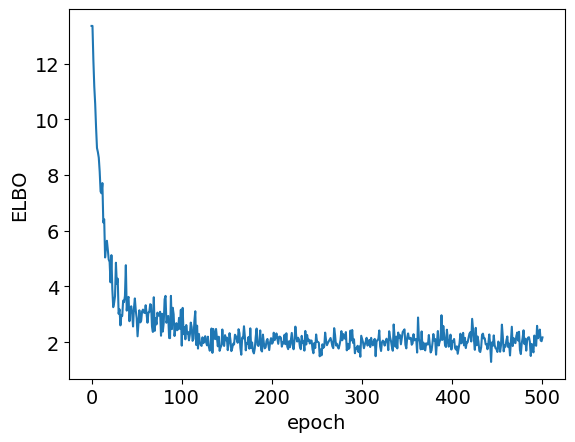

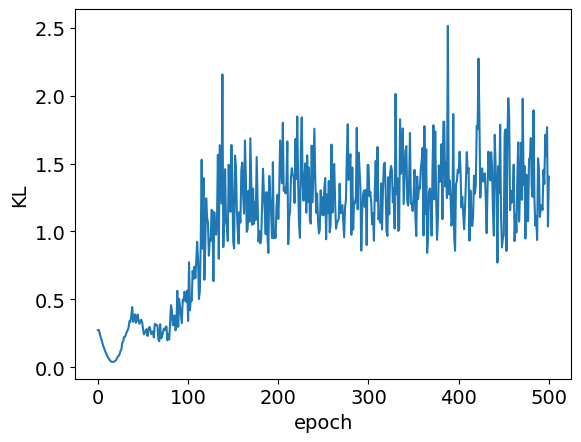

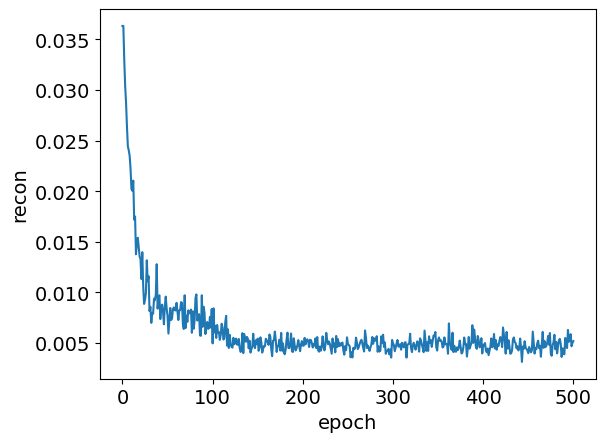

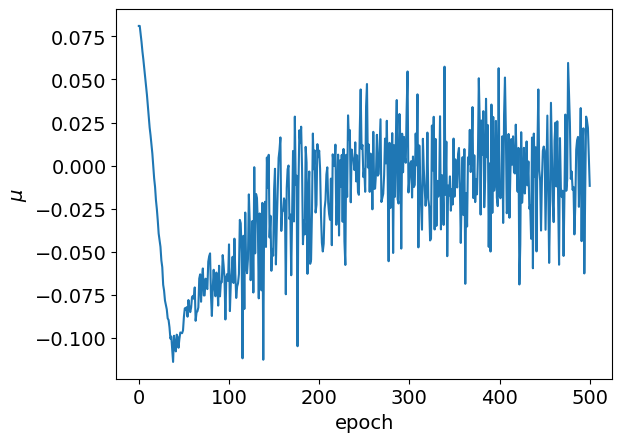

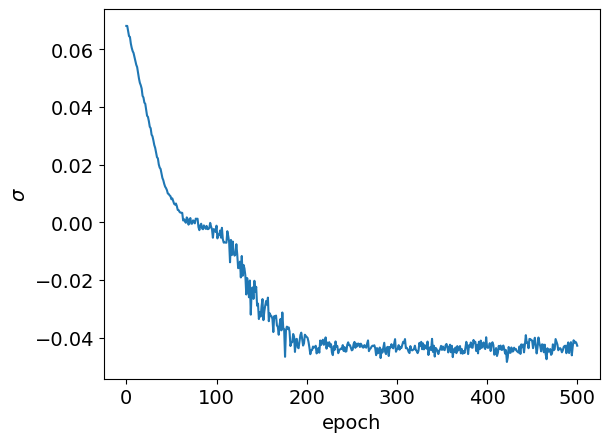

In [134]:
fig, ax = plt.subplots()
ax.plot(metrics['elbo'])
ax.set_ylabel('ELBO')
ax.set_xlabel('epoch')
plt.savefig(f'elbo.pdf', bbox_inches='tight')

fig, ax = plt.subplots()
ax.plot(metrics['kl'])
ax.set_ylabel('KL')
ax.set_xlabel('epoch')
plt.savefig(f'kl.pdf', bbox_inches='tight')

fig, ax = plt.subplots()
ax.plot(metrics['recon_loss'])
ax.set_ylabel('recon')
ax.set_xlabel('epoch')
plt.savefig(f'recon.pdf', bbox_inches='tight')

fig, ax = plt.subplots()
ax.plot(metrics['mu'])
ax.set_ylabel('$\mu$')
ax.set_xlabel('epoch')
plt.savefig(f'mu.pdf', bbox_inches='tight')

fig, ax = plt.subplots()
ax.plot(metrics['std'])
ax.set_ylabel('$\sigma$')
ax.set_xlabel('epoch')
plt.savefig(f'sigma.pdf', bbox_inches='tight')


sig_1300_1
torch.Size([1809, 6])
sig_300_1
torch.Size([1809, 6])


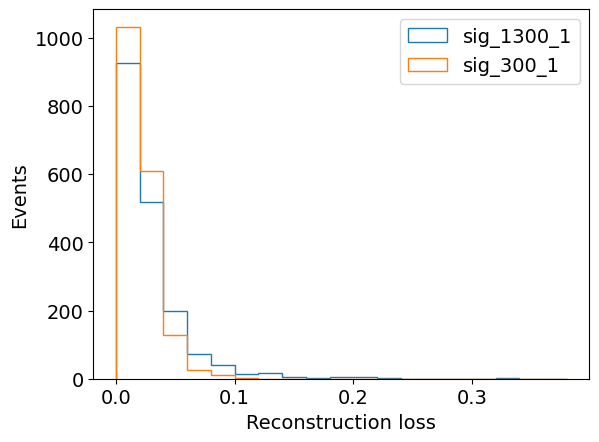

In [137]:
fig, ax = plt.subplots()
outputDists = {}
inputDists = {}
for sampName in sorted(pandas.unique(scaledData.sampName)):
    inputDists[sampName] = scaledData[scaledData.sampName==sampName][trainBranches].to_numpy()
    tempData = torch.Tensor(inputDists[sampName])
    # if torch.cuda.is_available():
    #     tempData = tempData.cuda()
    print(sampName)
    x_hat, mu, logvar, recon_loss, kld, loss = model.forward(tempData)
    outputDists[sampName] = x_hat.detach().numpy()
    print(recon_loss.shape)
    ax.hist(recon_loss.detach().numpy().sum(axis=1), bins=[0.02*i for i in range(20)], histtype='step', label=sampName)

ax.set_xlabel('Reconstruction loss')
ax.set_ylabel('Events')
ax.legend()
plt.savefig(f'recon.pdf', bbox_inches='tight')

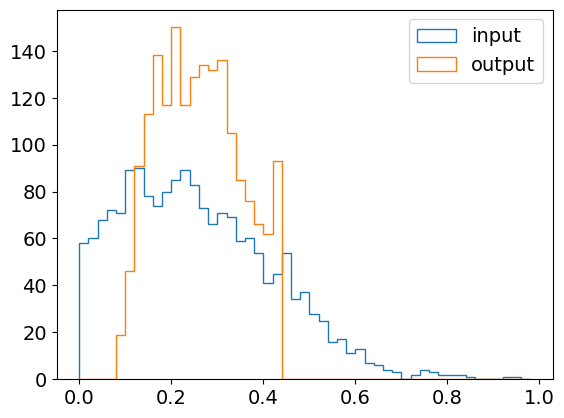

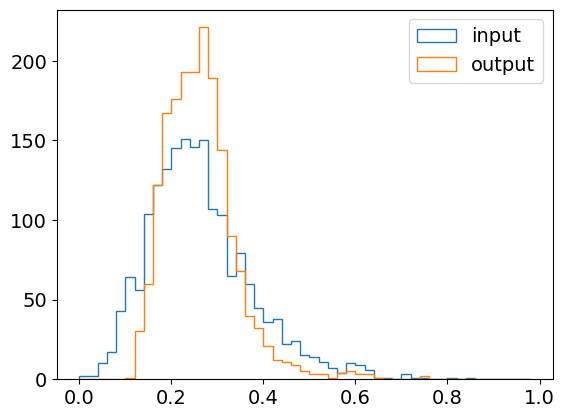

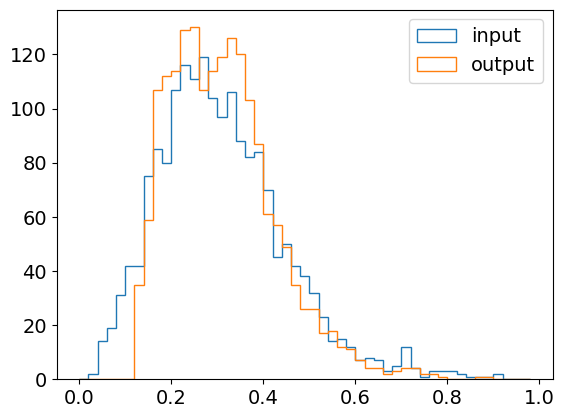

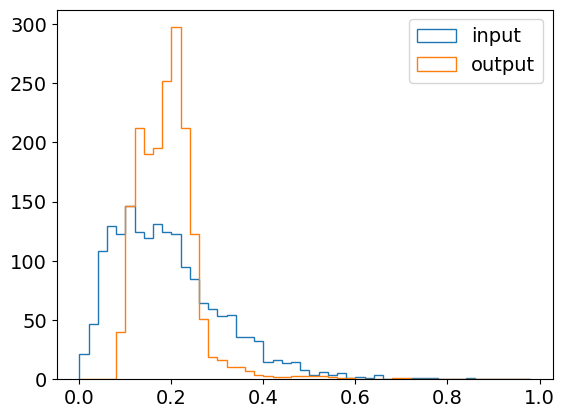

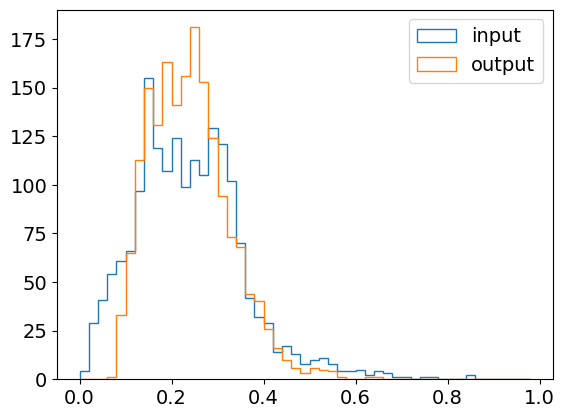

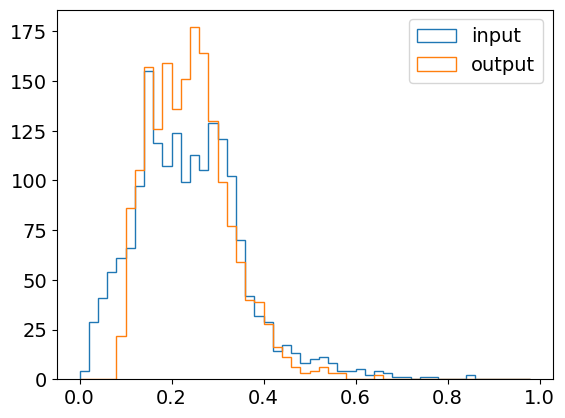

In [136]:
for varI in range(list(inputDists.values())[0].shape[1]):
    for sampName in ['sig_1300_1']:#inputDists:
        fig, ax = plt.subplots()
        ax.hist(inputDists[sampName][:,varI], bins=[0.02*i for i in range(50)], histtype='step', label='input')
        ax.hist(outputDists[sampName][:,varI], bins=[0.02*i for i in range(50)], histtype='step', label='output')
        ax.legend()